In [1]:
import sys
import argparse
import yaml

import cv2
import torch
from torch.autograd import Variable

from models.yolov3 import *
from utils.utils import *
from utils.parse_yolo_weights import parse_yolo_weights
from utils.vis_bbox import vis_bbox

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cfg_path = './config/gaussian_yolov3_eval.cfg'
ckpt_path = './logs/exp_10/snapshot483000.ckpt'

detect_thresh = 0.28
gpu = -1

image_path = './data/mountain.png'
#image_path = './data/uploads%2Fcard%2Fimage%2F33049%2FAP_401218737614.jpg%2F950x534__filters:quality(80).jpg?signature=yr4OwQup-02h2S0WvIxWirSm4FQ='

In [3]:
with open(cfg_path, 'r') as f:
    cfg = yaml.load(f)

imgsize = cfg['TEST']['IMGSIZE']
model = YOLOv3(cfg['MODEL'])

confthre = cfg['TEST']['CONFTHRE'] 
nmsthre = cfg['TEST']['NMSTHRE']

gaussian = cfg['MODEL']['GAUSSIAN']

if detect_thresh:
    confthre = detect_thresh

/home/kimura/PyTorch_YOLOv3/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Gaussian YOLOv3
Gaussian YOLOv3
Gaussian YOLOv3


In [4]:
img = cv2.imread(image_path)
#img = cv2.resize(img, (int(0.25 * img.shape[1]), int(0.25 * img.shape[0])))

img_raw = img.copy()[:, :, ::-1].transpose((2, 0, 1))
img, info_img = preprocess(img, imgsize, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)

if gpu >= 0:
    model.cuda()
    img = Variable(img.type(torch.cuda.FloatTensor))
else:
    img = Variable(img.type(torch.FloatTensor))

print("loading checkpoint %s" % (ckpt_path))
state = torch.load(ckpt_path)
if 'model_state_dict' in state.keys():
    model.load_state_dict(state['model_state_dict'])
else:
    model.load_state_dict(state)

model.eval();

loading checkpoint ./logs/exp_10/snapshot483000.ckpt


/home/kimura/PyTorch_YOLOv3/venv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


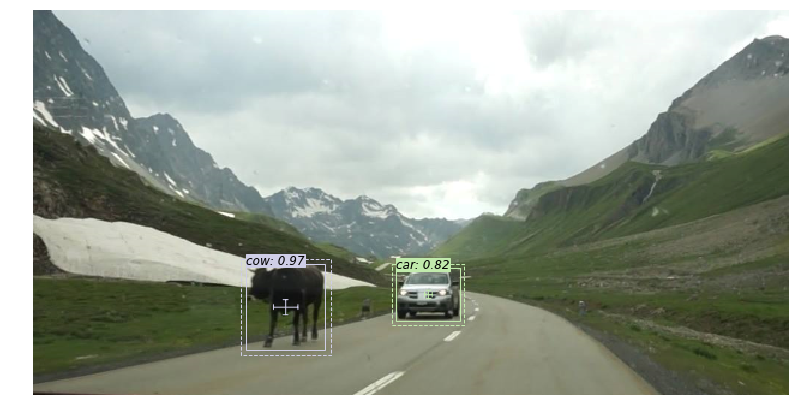

In [5]:
with torch.no_grad():
    outputs = model(img)
    outputs = postprocess(outputs, 80, confthre, nmsthre)

if outputs[0] is None:
    print("No Objects Deteted!!")
    sys.exit(0)

coco_class_names, coco_class_ids, coco_class_colors = get_coco_label_names()

bboxes = list()
classes = list()
scores = list()
colors = list()
sigmas = list()

for output in outputs[0]:
    x1, y1, x2, y2, conf, cls_conf, cls_pred = output[:7]
    if gaussian:
        sigma_x, sigma_y, sigma_w, sigma_h = output[7:]
        sigmas.append([sigma_x, sigma_y, sigma_w, sigma_h])

    cls_id = coco_class_ids[int(cls_pred)]
    #print(int(x1), int(y1), int(x2), int(y2), float(conf), int(cls_pred))
    #print('\t+ Label: %s, Conf: %.5f' %
    #      (coco_class_names[cls_id], cls_conf.item()))
    box = yolobox2label([y1, x1, y2, x2], info_img)
    bboxes.append(box)
    classes.append(cls_id)
    scores.append(cls_conf * conf)
    colors.append(coco_class_colors[int(cls_pred)])
    
vis_bbox(
    img_raw, bboxes, label=classes, score=scores, label_names=coco_class_names,
    sigma=sigmas, instance_colors=colors, linewidth=1)